# Most probably path predictions

### Introduction

The ability to drive conversion between different cell states has
  garnered a great deal of attention as a promising avenue for disease
  modeling. A fundamental challenge in the field
  of stem cell biology is to identify and assess the feasibility of
  optimal paths and key TFs (transcription factors) of such
  interconversions (Figure 6A of :cite:p:`QIU2022`). The least action path (LAP) is a principled method that has previously been used in
  theoretical efforts to predict the most probable path a cell will
  follow during fate transition. Specifically, the optimal path between any two cell states
  (e.g. the fixed point of HSCs and that of megakaryocytes) is searched
  by variating the continuous path connecting the source state to the
  target while minimizing its action and updating the associated
  transition time. The resultant least action path has the highest
  transition probability and is associated with a particular transition
  time. Once the LAP is identified, we can focus only on TFs and rank them by the path integral of the mean square displacement (MSD) of gene expression with respect to the initial expression to identify key transcription factors of the associated cell fate transitions.

In this tutorial, we will demonstrate how to 
- perform LAP analyses;
- visualize transition paths found by the LAP approach on the vector field;
- plot heatmaps of actions and transition times matrix between all hematopoietic cell types;
- prioritize transcription factors of each predicted optimal path;
- ROC analyses of the LAP predictions.

Import relevant packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot
import matplotlib.pyplot as plt

import sys
import os

import dynamo as dyn

dyn.dynamo_logger.main_silence()

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


Let us first load the human hematopoiesis scNT-seq dataset, which has stored as a sample dataset within dynamo that can be download directly using the above function, produced in this study (:cite:p:`QIU2022`). In this tutorial we will focus on analyzing this scNT-seq dataset because decades of researches in hematopoiesis make it a well suited system for testing LAP predictions. 


In [2]:
adata_labeling = dyn.sample_data. hematopoiesis()

In [3]:
adata_labeling

AnnData object with n_obs × n_vars = 1947 × 1956
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

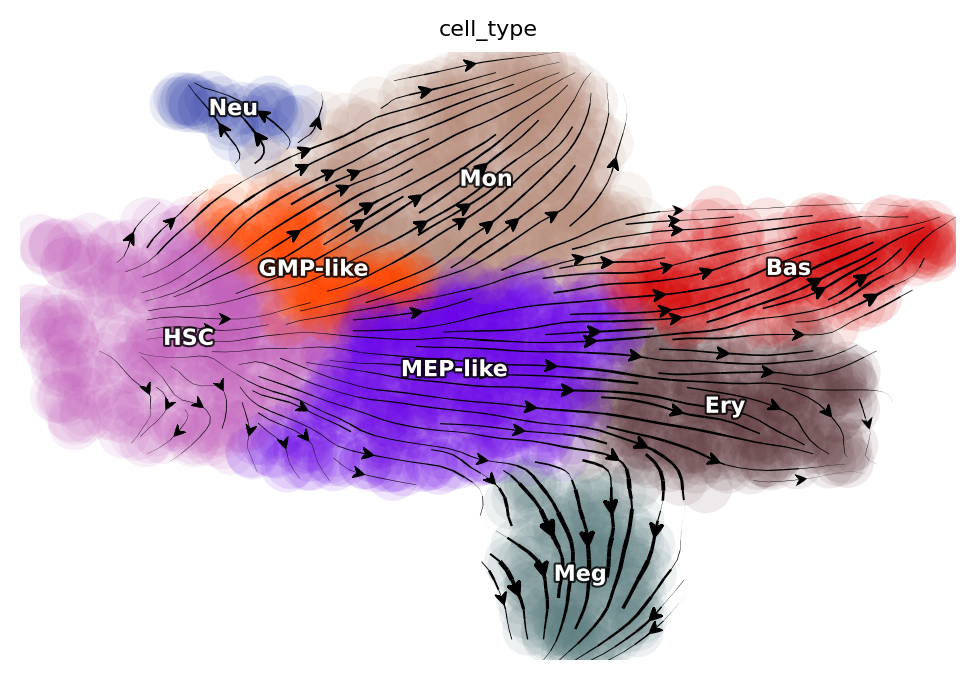

In [4]:
dyn.pl.streamline_plot(adata_labeling, basis="umap", color="cell_type")

HSC_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "HSC")
Meg_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Meg")
Ery_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Ery")
Bas_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Bas")
Mon_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Mon")
Neu_cells = dyn.tl.select_cell(adata_labeling, "cell_type", "Neu")

We select the five closest cells of the identified attractors that correspond to each of the six cell types to represent the typical cell state of these cells (note that attractors often don't correspond to any particular cell).


In [5]:
from dynamo.tools.utils import nearest_neighbors

extreme_points = np.array(
    [
        [8.45201833, 9.37697661],
        [14.00630381, 2.53853712],
        [17.30550636, 6.81561775],
        [18.06891717, 11.9840678],
        [14.13613403, 15.22244713],
        [9.72644402, 14.83745969],
    ]
)

HSC_cells_indices = nearest_neighbors(extreme_points[0], adata_labeling.obsm["X_umap"])
Meg_cells_indices = nearest_neighbors(extreme_points[1], adata_labeling.obsm["X_umap"])
Ery_cells_indices = nearest_neighbors(extreme_points[2], adata_labeling.obsm["X_umap"])
Bas_cells_indices = nearest_neighbors(extreme_points[3], adata_labeling.obsm["X_umap"])
Mon_cells_indices = nearest_neighbors(extreme_points[4], adata_labeling.obsm["X_umap"])
Neu_cells_indices = nearest_neighbors(extreme_points[5], adata_labeling.obsm["X_umap"])


/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


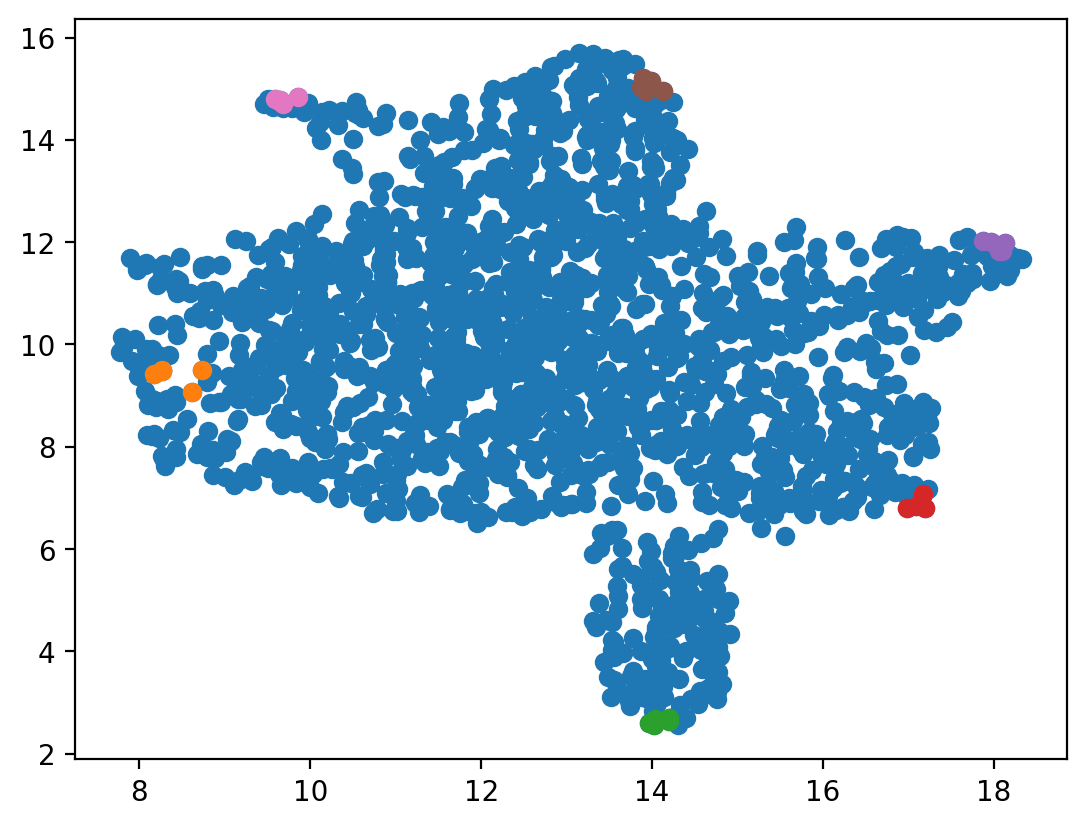

In [6]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(4, 4))

plt.scatter(*adata_labeling.obsm["X_umap"].T)
for indices in [
    HSC_cells_indices,
    Meg_cells_indices,
    Ery_cells_indices,
    Bas_cells_indices,
    Mon_cells_indices,
    Neu_cells_indices,
]:
    plt.scatter(*adata_labeling[indices[0]].obsm["X_umap"].T)


We can see, for example, the cell indices ``1587, 1557, 1725, 1091, 1070`` are the nearest cells to the identified HSC attractor. 


In [7]:
HSC_cells_indices


array([[1587, 1557, 1725, 1091, 1070]])

Now we are ready to perform the LAP analyses. We will start with computing the neighbor graph of cells in the umap space (pca space works too) and use the shortest paths between any two represented cells as the initial guess of the LAP. We will next run the LAP analyses between all pair-wise combinations of cells. We can either perform the LAP analyses on the UMAP space or in the PCA space, using the vector field reconstructed in UMAP or PCA space, respectively. With the vector field learned in the PCA space, we can then further projected the optimized LAP back to the original gene expression space to reveal the transcriptomic kinetics along the LAP. 


### Compute neighbor graph based on `umap`

In [8]:
dyn.tl.neighbors(adata_labeling, basis="umap", result_prefix="umap")


|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:umap
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> <insert> umap_connectivities to obsp in AnnData Object.
|-----> <insert> umap_distances to obsp in AnnData Object.
|-----> <insert> umap_neighbors to uns in AnnData Object.
|-----> <insert> umap_neighbors.indices to uns in AnnData Object.
|-----> <insert> umap_neighbors.params to uns in AnnData Object.


AnnData object with n_obs × n_vars = 1947 × 1956
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

### Run pairwise least action path analyses among six distinct hematopoietic cell types

This section will demonstrate how to compute LAPs for all possible cell type transition pairs in our scNT-seq dataset. The corresponding function in
*dynamo* is ``dyn.pd.least_action``. This function takes an ``adata`` object that has continous vector field reconstructed, a start
cell and a target cell to compute least action path or most probable path between them. As shown
above, either UMAP or PCA basis can be used. Here we use the UMAP basis to visualize the LAP and the PCA basis 
for downstream transcription factor prioritization and other analyses.

Note that the following block also demonstrates using the `GeneTrajectory` function to reverse project the optimized LAP in PCA space back to the original gene expression space to reveal the transcriptomic kinetics along the LAP. We then calculate the accumulative MSD (mean square displacement) with respect to the initial state of each gene along the LAP in the original gene expression space (with `calc_msd` function) and use this score to prioritize the importance of each gene (with `rank_genes` function). Genes with top MSD have higher variances with respect to the initial state and will be ranked higher, which may also indicate key roles in making the cell fate conversions. 

Please refer to the API documentation of each of these functions for
detailed explanation of their input parameters, output, etc. Please also check our primers on the optimal path and the Cell paper for more in-depth understandings. 

In [9]:
%%capture

dyn.dynamo_logger.main_silence()
transition_graph = {}
cell_type = ["HSC", "Meg", "Ery", "Bas", "Mon", "Neu"]
start_cell_indices = [
    HSC_cells_indices,
    Meg_cells_indices,
    Ery_cells_indices,
    Bas_cells_indices,
    Mon_cells_indices,
    Neu_cells_indices,
]
end_cell_indices = start_cell_indices
for i, start in enumerate(start_cell_indices):
    for j, end in enumerate(end_cell_indices):
        if start is not end:
            min_lap_t = True if i == 0 else False
            dyn.pd.least_action(
                adata_labeling,
                [adata_labeling.obs_names[start[0]][0]],
                [adata_labeling.obs_names[end[0]][0]],
                basis="umap",
                adj_key="X_umap_distances",
                min_lap_t= min_lap_t,
                EM_steps=2,
            )
            dyn.pl.least_action(adata_labeling, basis="umap")
            lap = dyn.pd.least_action(
                adata_labeling,
                [adata_labeling.obs_names[start[0]][0]],
                [adata_labeling.obs_names[end[0]][0]],
                basis="pca",
                adj_key="cosine_transition_matrix",
                min_lap_t=min_lap_t,
                EM_steps=2,
            )
            dyn.pl.kinetic_heatmap(
                adata_labeling,
                basis="pca",
                mode="lap",
                genes=adata_labeling.var_names[adata_labeling.var.use_for_transition],
                project_back_to_high_dim=True,
            )
            # The `GeneTrajectory` class can be used to output trajectories for any set of genes of interest
            gtraj = dyn.pd.GeneTrajectory(adata_labeling)
            gtraj.from_pca(lap.X, t=lap.t)
            gtraj.calc_msd()
            ranking = dyn.vf.rank_genes(adata_labeling, "traj_msd")

            print(start, "->", end)
            genes = ranking[:5]["all"].to_list()
            arr = gtraj.select_gene(genes)

            dyn.pl.multiplot(lambda k: [plt.plot(arr[k, :]), plt.title(genes[k])], np.arange(len(genes)))

            transition_graph[cell_type[i] + "->" + cell_type[j]] = {
                "lap": lap,
                "LAP_umap": adata_labeling.uns["LAP_umap"],
                "LAP_pca": adata_labeling.uns["LAP_pca"],
                "ranking": ranking,
                "gtraj": gtraj,
            }


|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [4.7540s]
|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [81.5235s]
|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [6.0830s]
|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [81.5128s]
|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [6.5485s]
|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [98.4507s]
|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [5.9416s]
|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [90.9794s]
|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating throug

## Visualize developmental LAPs

In [10]:
develope_keys = ["HSC->Meg", "HSC->Ery", "HSC->Bas", "HSC->Mon", "HSC->Neu"]
reprogram_keys = ["Meg->HSC", "Ery->HSC", "Bas->HSC", "Mon->HSC", "Neu->HSC"]
transdifferentiation = [
    "Ery->Meg",
    "Neu->Bas",
    "Mon->Ery",
    "Bas->Meg",
    "Neu->Meg",
    "Meg->Bas",
    "Mon->Bas",
    "Neu->Mon",
    "Meg->Ery",
    "Ery->Bas",
    "Bas->Mon",
    "Mon->Neu",
    "Neu->Ery",
    "Mon->Meg",
    "Bas->Neu",
    "Meg->Neu",
    "Ery->Mon",
    "Meg->Mon",
    "Ery->Neu",
    "Bas->Ery",
]


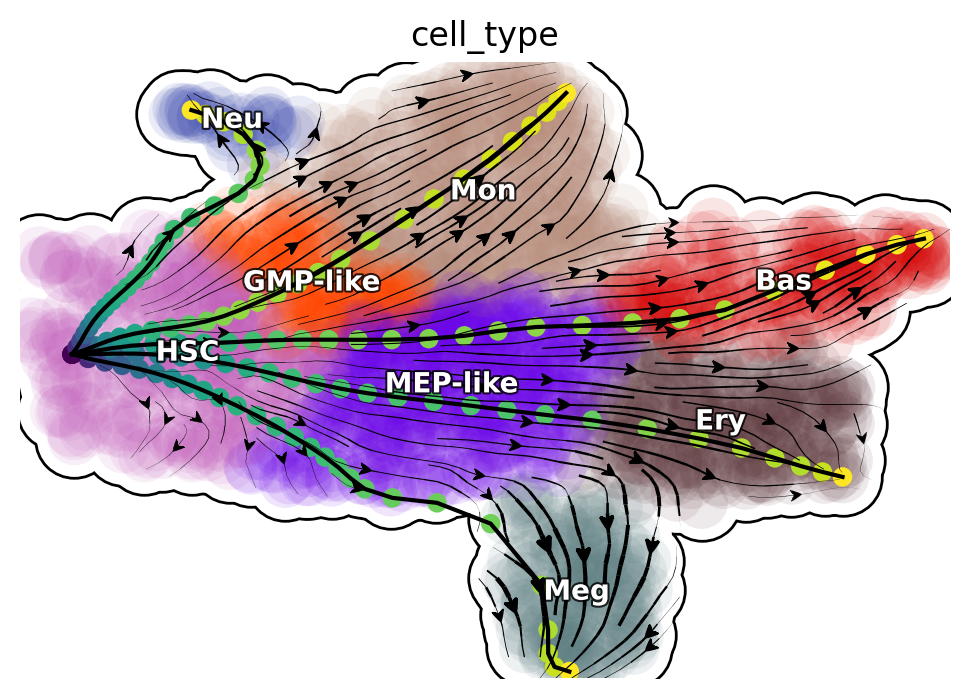

In [11]:
from dynamo.plot.utils import map2color
def plot_lap(paths):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax = dyn.pl.streamline_plot(
        adata_labeling, basis="umap", save_show_or_return="return", ax=ax, color="cell_type", frontier=True
    )
    ax = ax[0]
    x, y = 0, 1

    # plot paths
    for path in paths:
        lap_dict = transition_graph[path]["LAP_umap"]
        for prediction, action in zip(lap_dict["prediction"], lap_dict["action"]):
            ax.scatter(*prediction[:, [x, y]].T, c=map2color(action))
            ax.plot(*prediction[:, [x, y]].T, c="k")
plot_lap(develope_keys)



**Reprogram LAPs**

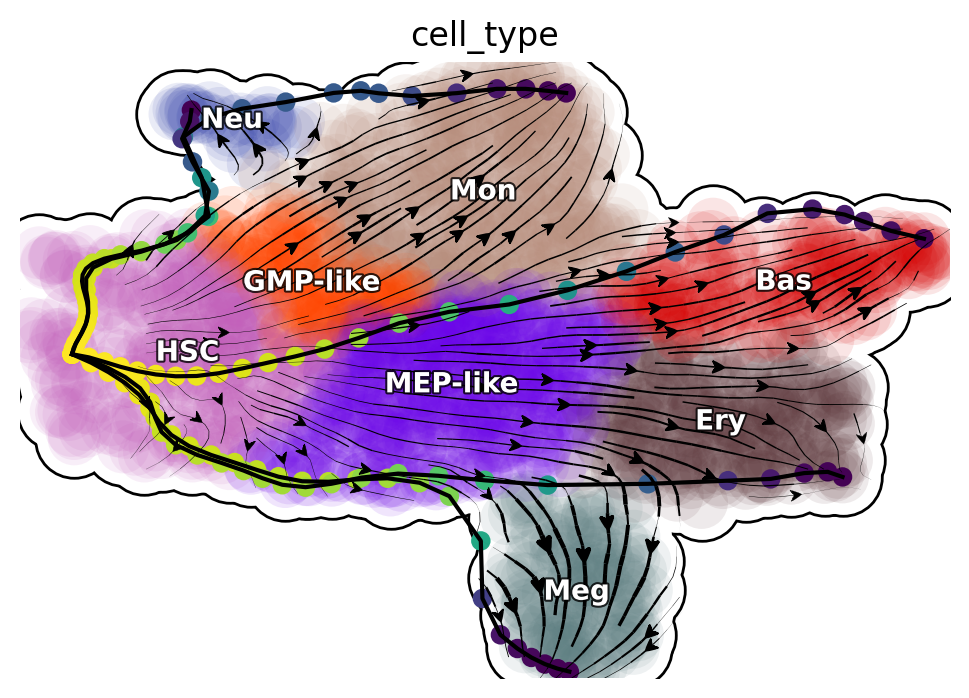

In [12]:
plot_lap(reprogram_keys)


**Transdifferentiation LAPs**

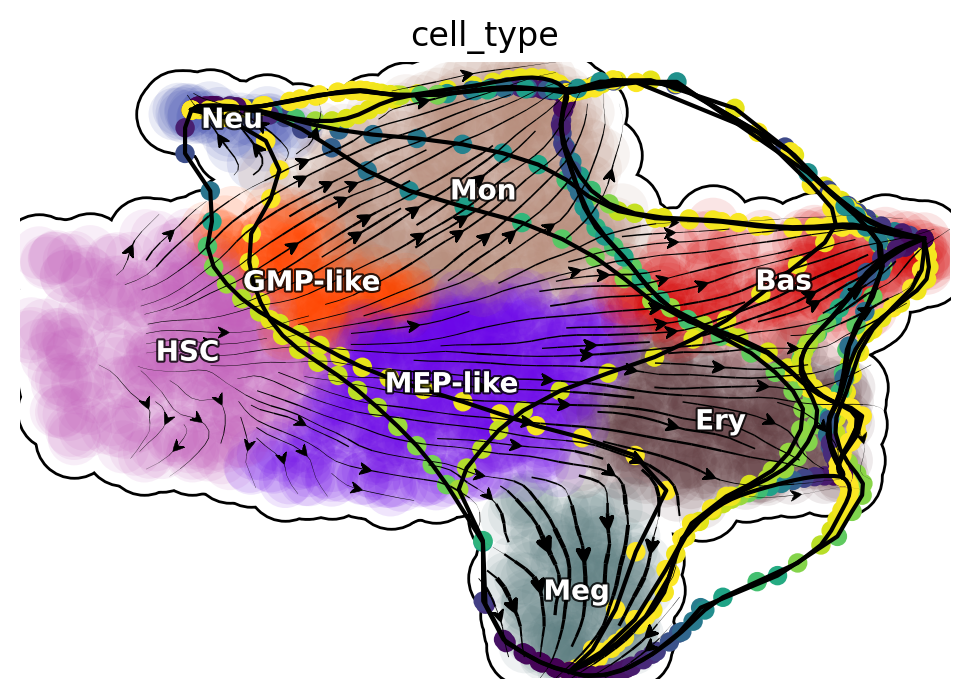

In [13]:

plot_lap(transdifferentiation)


Next, we will focus on transcription factors (TFs) and rank them based on their MSD along the LAP path to prioritize the importance of each TF. Meanwhile, we will also keep the action (an functional of the LAP) and the least action path time, with `action_df` and `t_df`, respectively, of each of these conversions. 

In [14]:
human_tfs = dyn.sample_data.human_tfs()
human_tfs_names = list(human_tfs["Symbol"])


In [15]:
action_df = pd.DataFrame(index=cell_type, columns=cell_type)
t_df = pd.DataFrame(index=cell_type, columns=cell_type)
for i, start in enumerate(
    [
        HSC_cells_indices,
        Meg_cells_indices,
        Ery_cells_indices,
        Bas_cells_indices,
        Mon_cells_indices,
        Neu_cells_indices,
    ]
):
    for j, end in enumerate(
        [
            HSC_cells_indices,
            Meg_cells_indices,
            Ery_cells_indices,
            Bas_cells_indices,
            Mon_cells_indices,
            Neu_cells_indices,
        ]
    ):
        if start is not end:
            print(cell_type[i] + "->" + cell_type[j], end=",")
            lap = transition_graph[cell_type[i] + "->" + cell_type[j]]["lap"]  # lap
            gtraj = transition_graph[cell_type[i] + "->" + cell_type[j]]["gtraj"]
            ranking = transition_graph[cell_type[i] + "->" + cell_type[j]]["ranking"].copy()
            ranking["TF"] = [i in human_tfs_names for i in list(ranking["all"])]
            genes = ranking.query("TF == True").head(10)["all"].to_list()
            arr = gtraj.select_gene(genes)
            action_df.loc[cell_type[i], cell_type[j]] = lap.action()[-1]
            t_df.loc[cell_type[i], cell_type[j]] = lap.t[-1]


HSC->Meg,HSC->Ery,HSC->Bas,HSC->Mon,HSC->Neu,Meg->HSC,Meg->Ery,Meg->Bas,Meg->Mon,Meg->Neu,Ery->HSC,Ery->Meg,Ery->Bas,Ery->Mon,Ery->Neu,Bas->HSC,Bas->Meg,Bas->Ery,Bas->Mon,Bas->Neu,Mon->HSC,Mon->Meg,Mon->Ery,Mon->Bas,Mon->Neu,Neu->HSC,Neu->Meg,Neu->Ery,Neu->Bas,Neu->Mon,

We now visualize the LAP time of all developmental LAPs. Interestingly, we show that the LAP time from HSC to Meg lineage LAP (28 hour) is the shortest among all
developmental LAPs, consistent with the fact that megakaryocyte is the earliest cell type to appear. The predicted 28 hours is also on the time-scale of what has been reported for the single HSC transplantation experiments. We want to note that because we used the metabolic labeling based scRNA-seq, we obtained absolute RNA velocity and thus we can predict the actual time (with units of hour) of the LAP, a rather remarkable feature of the labeling data. 

    integration time lineage
HSC              NaN     HSC
Meg        28.335868     Meg
Ery        46.227644     Ery
Bas        45.575254     Bas
Mon        41.797433     Mon
Neu        76.469544     Neu


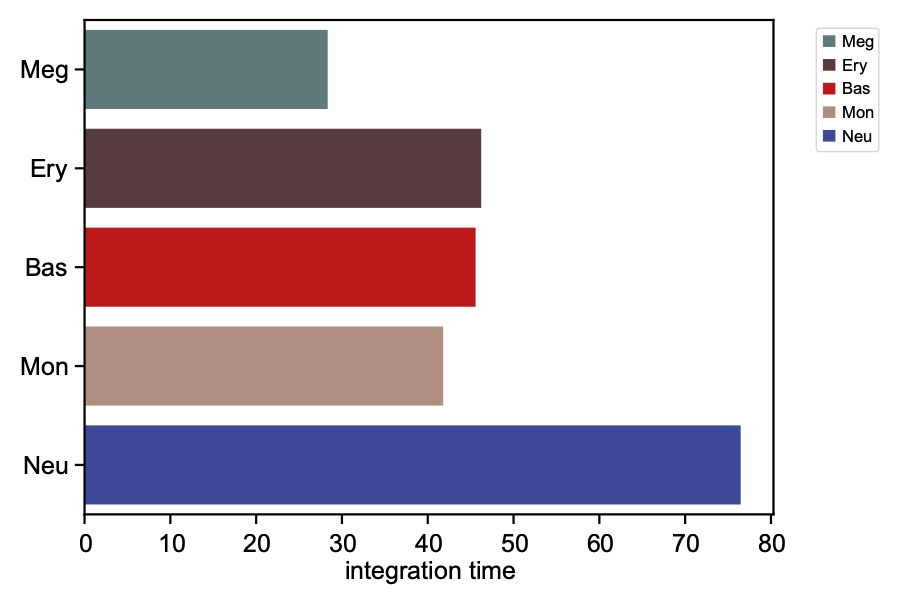

In [16]:
dyn.configuration.set_pub_style(scaler=1.5)
develop_time_df = pd.DataFrame({"integration time": t_df.iloc[0, :].T})
develop_time_df["lineage"] = ["HSC", "Meg", "Ery", "Bas", "Mon", "Neu"]
print(develop_time_df)
ig, ax = plt.subplots(figsize=(4, 3))
dynamo_color_dict = {
    "Mon": "#b88c7a",
    "Meg": "#5b7d80",
    "MEP-like": "#6c05e8",
    "Ery": "#5d373b",
    "Bas": "#d70000",
    "GMP-like": "#ff4600",
    "HSC": "#c35dbb",
    "Neu": "#2f3ea8",
}

sns.barplot(
    y="lineage",
    x="integration time",
    hue="lineage",
    data=develop_time_df.iloc[1:, :],
    dodge=False,
    palette=dynamo_color_dict,
    ax=ax,
)
ax.set_ylabel("")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


## Heatmap of LAP actions and LAP time matrices of pairwise cell fate conversions


Here we are going to visualize the transition matrices of actions and LAP time between all pair-wise cell type conversions with heatmaps. Overall, we find the the developmental LAP time is much larger than that of the dedifferentiation LAP while the action has the opposite pattern. 

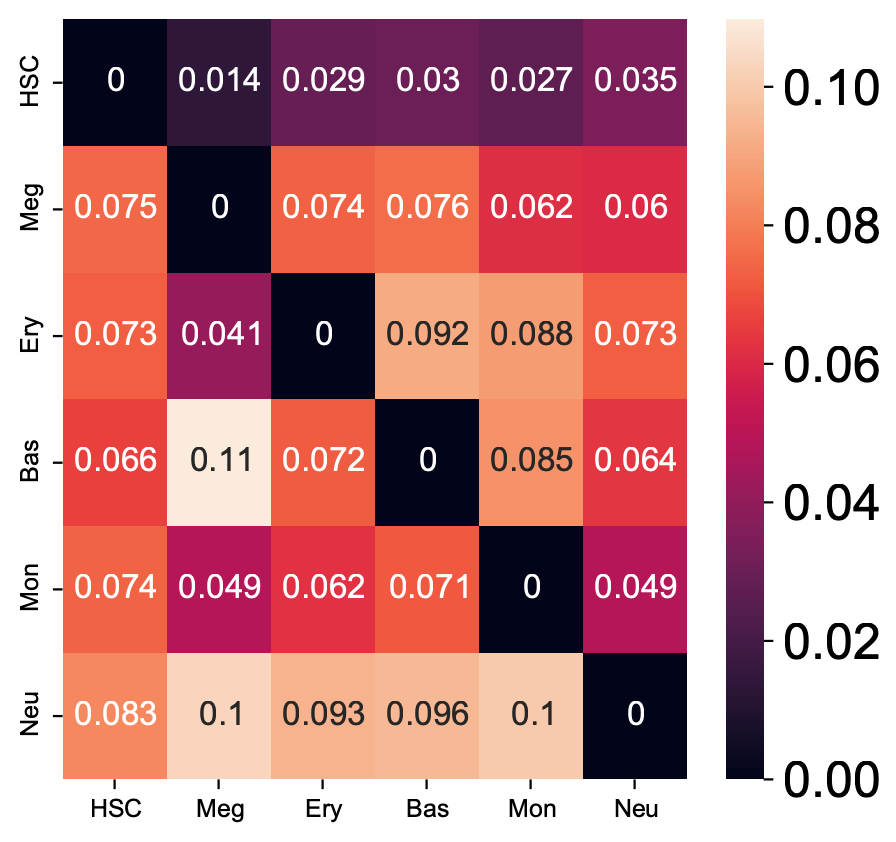

In [17]:
action_df = action_df.fillna(0)
f, ax = plt.subplots(figsize=(5, 5))
dyn.configuration.set_pub_style(scaler=3)
ax = sns.heatmap(action_df, annot=True, ax=ax, fmt=".2g")


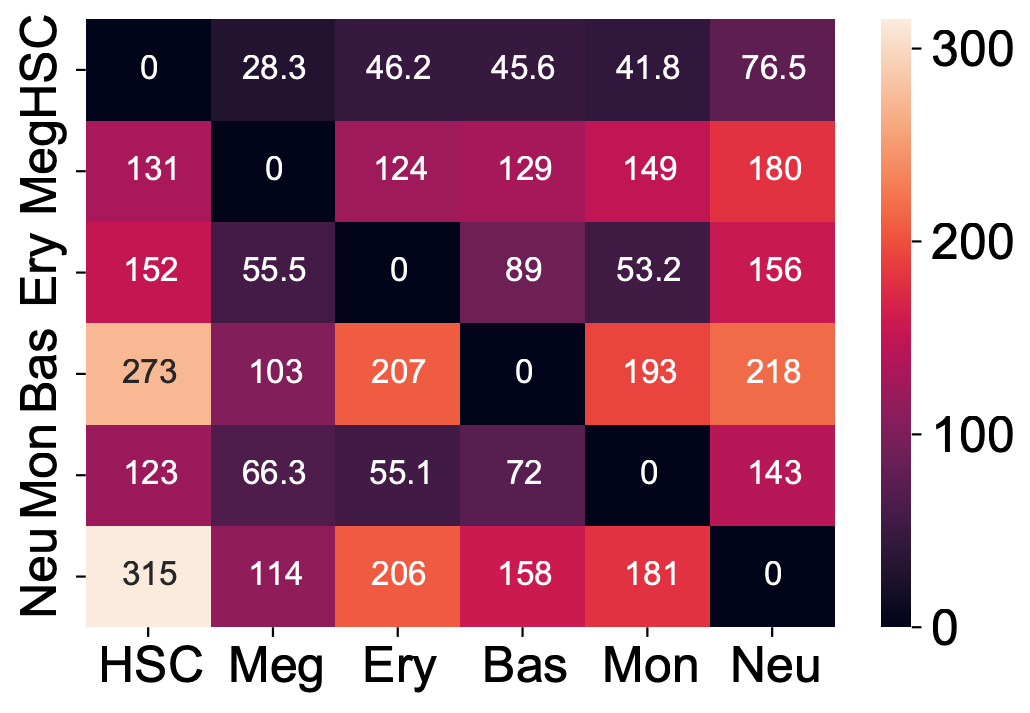

In [18]:
t_df = t_df.fillna(0)
dyn.configuration.set_pub_style(scaler=3)
ax = sns.heatmap(t_df, annot=True, fmt=".3g")


## Kinetics heatmap of gene expression dynamics along the LAP

As mentioned above, we are able to obtain the gene-wise kinetics when we reverse projected the LAP learned in PCA space back to gene-wise space. In this section we will show how to do so and we will create a kinetics heatmap of the transcriptomic dynamics along the LAP from HSC to basophil lineage. We will rely on mainly two functions, ``dyn.pd.least_action``  and ``dyn.pl.kinetic_heatmap``. ``dyn.pd.least_action`` can be used to computes the optimal paths between any two cell states, as mentioned above while ``dyn.pl.kinetic_heatmap`` can be used to plot kinetics
heatmap.

Here we will identify the LAP from the HSC to basophil lineage, and thus one typical HSC and one typical basophil cell are chosen as the initial and target cell, respectively. 

In [19]:
init_cells = [adata_labeling.obs_names[HSC_cells_indices[0][0]]]
target_cells = [adata_labeling.obs_names[Bas_cells_indices[0][0]]]
print("init cells:", init_cells)
print("target cells:", target_cells)

init cells: ['GGGGGGCGGCCT-JL_10']
target cells: ['GCAGCGAAGGCA-JL12_0']


Now let us find the optimal path between HSC to basophil lineage via the ``least_action`` function.

In [20]:
dyn.configuration.set_pub_style(scaler=0.6)

lap = dyn.pd.least_action(
    adata_labeling,
    init_cells=init_cells,
    target_cells=target_cells,
    basis="pca",
    adj_key="cosine_transition_matrix",
)


|-----> [iterating through 1 pairs] in progress: 100.0000%

/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [9.4687s]


Now let us plot the kinetic heatmap of the gene expression kinetics of all transcription factors (restricted only to those that are used for calculating the velocity transition matrix) along the LAP from HSC to basophil lineage.  

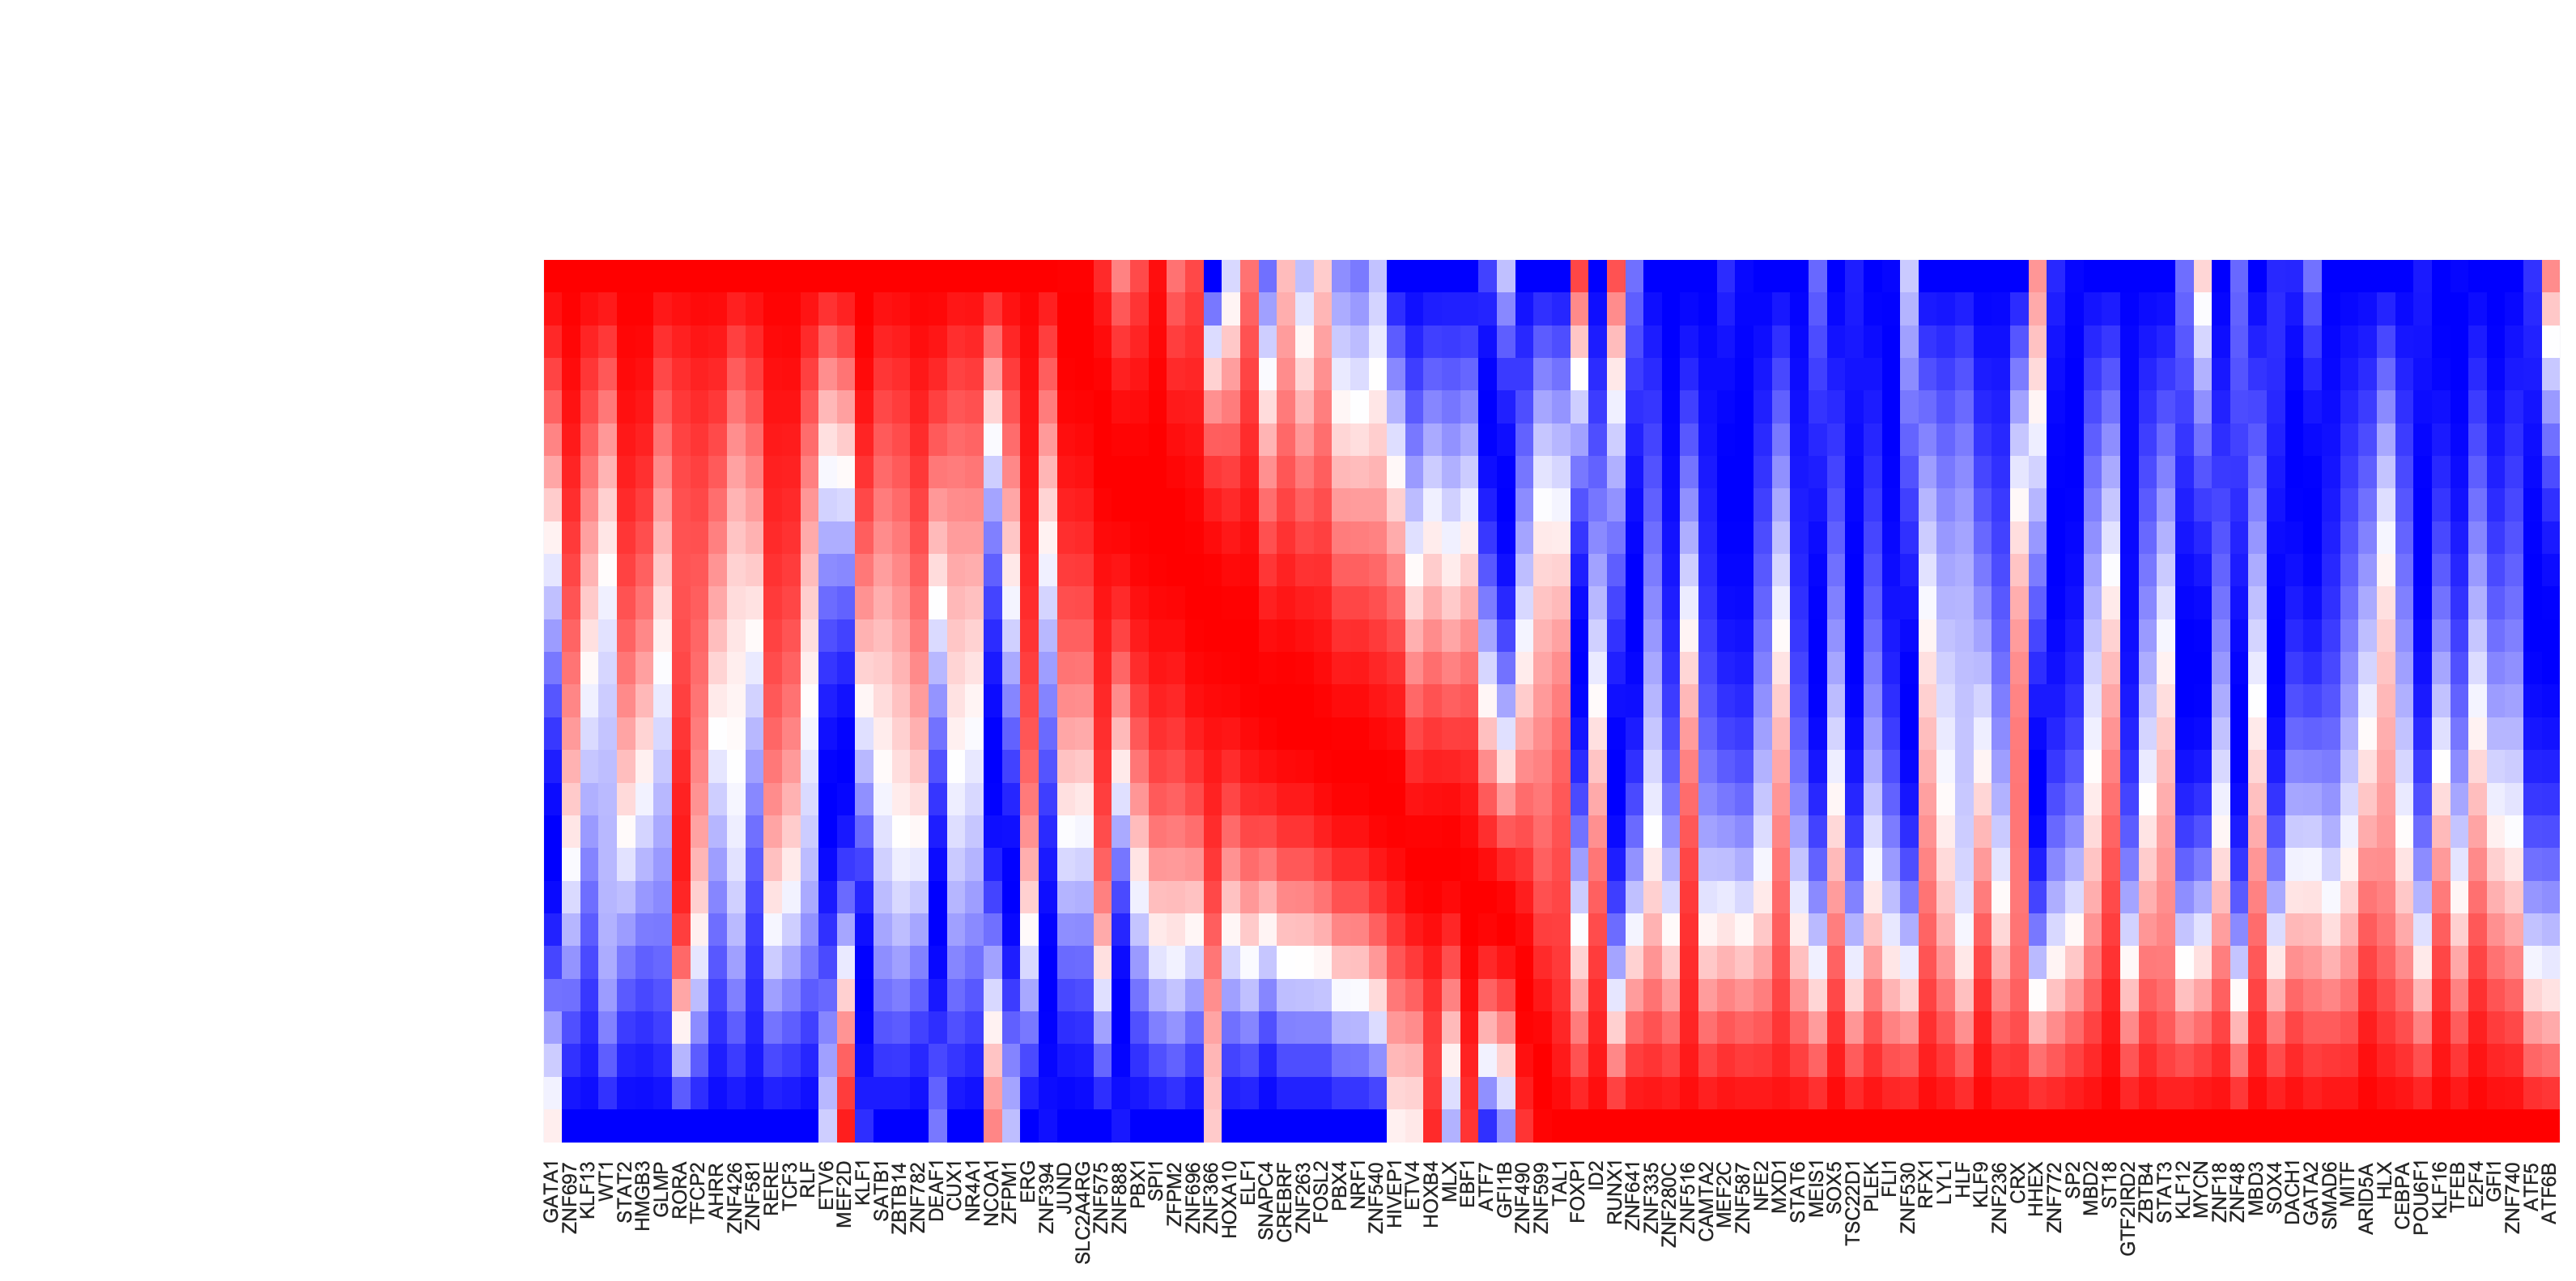

In [21]:
from matplotlib import pyplot, transforms

is_human_tfs = [gene in human_tfs_names for gene in adata_labeling.var_names[adata_labeling.var.use_for_transition]]
human_genes = adata_labeling.var_names[adata_labeling.var.use_for_transition][is_human_tfs]
dyn.configuration.set_pub_style(scaler=0.6)

sns.set(font_scale=0.8)
sns_heatmap = dyn.pl.kinetic_heatmap(
    adata_labeling,
    basis="pca",
    mode="lap",
    figsize=(16, 8),
    genes=human_genes,
    project_back_to_high_dim=True,
    save_show_or_return="return",
    color_map="bwr",
    transpose=True,
    xticklabels=True,
    yticklabels=False,
)
plt.setp(sns_heatmap.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()


Now let us swap ``target_cells`` and ``init_cells``, when passing parameters into ``dyn.pd.least_action``, to draw the  the kinetic heatmap of the gene expression kinetics of all transcription factors along the LAP from basophil to HSC. 


|-----> [iterating through 1 pairs] in progress: 100.0000%

/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [25.2263s]


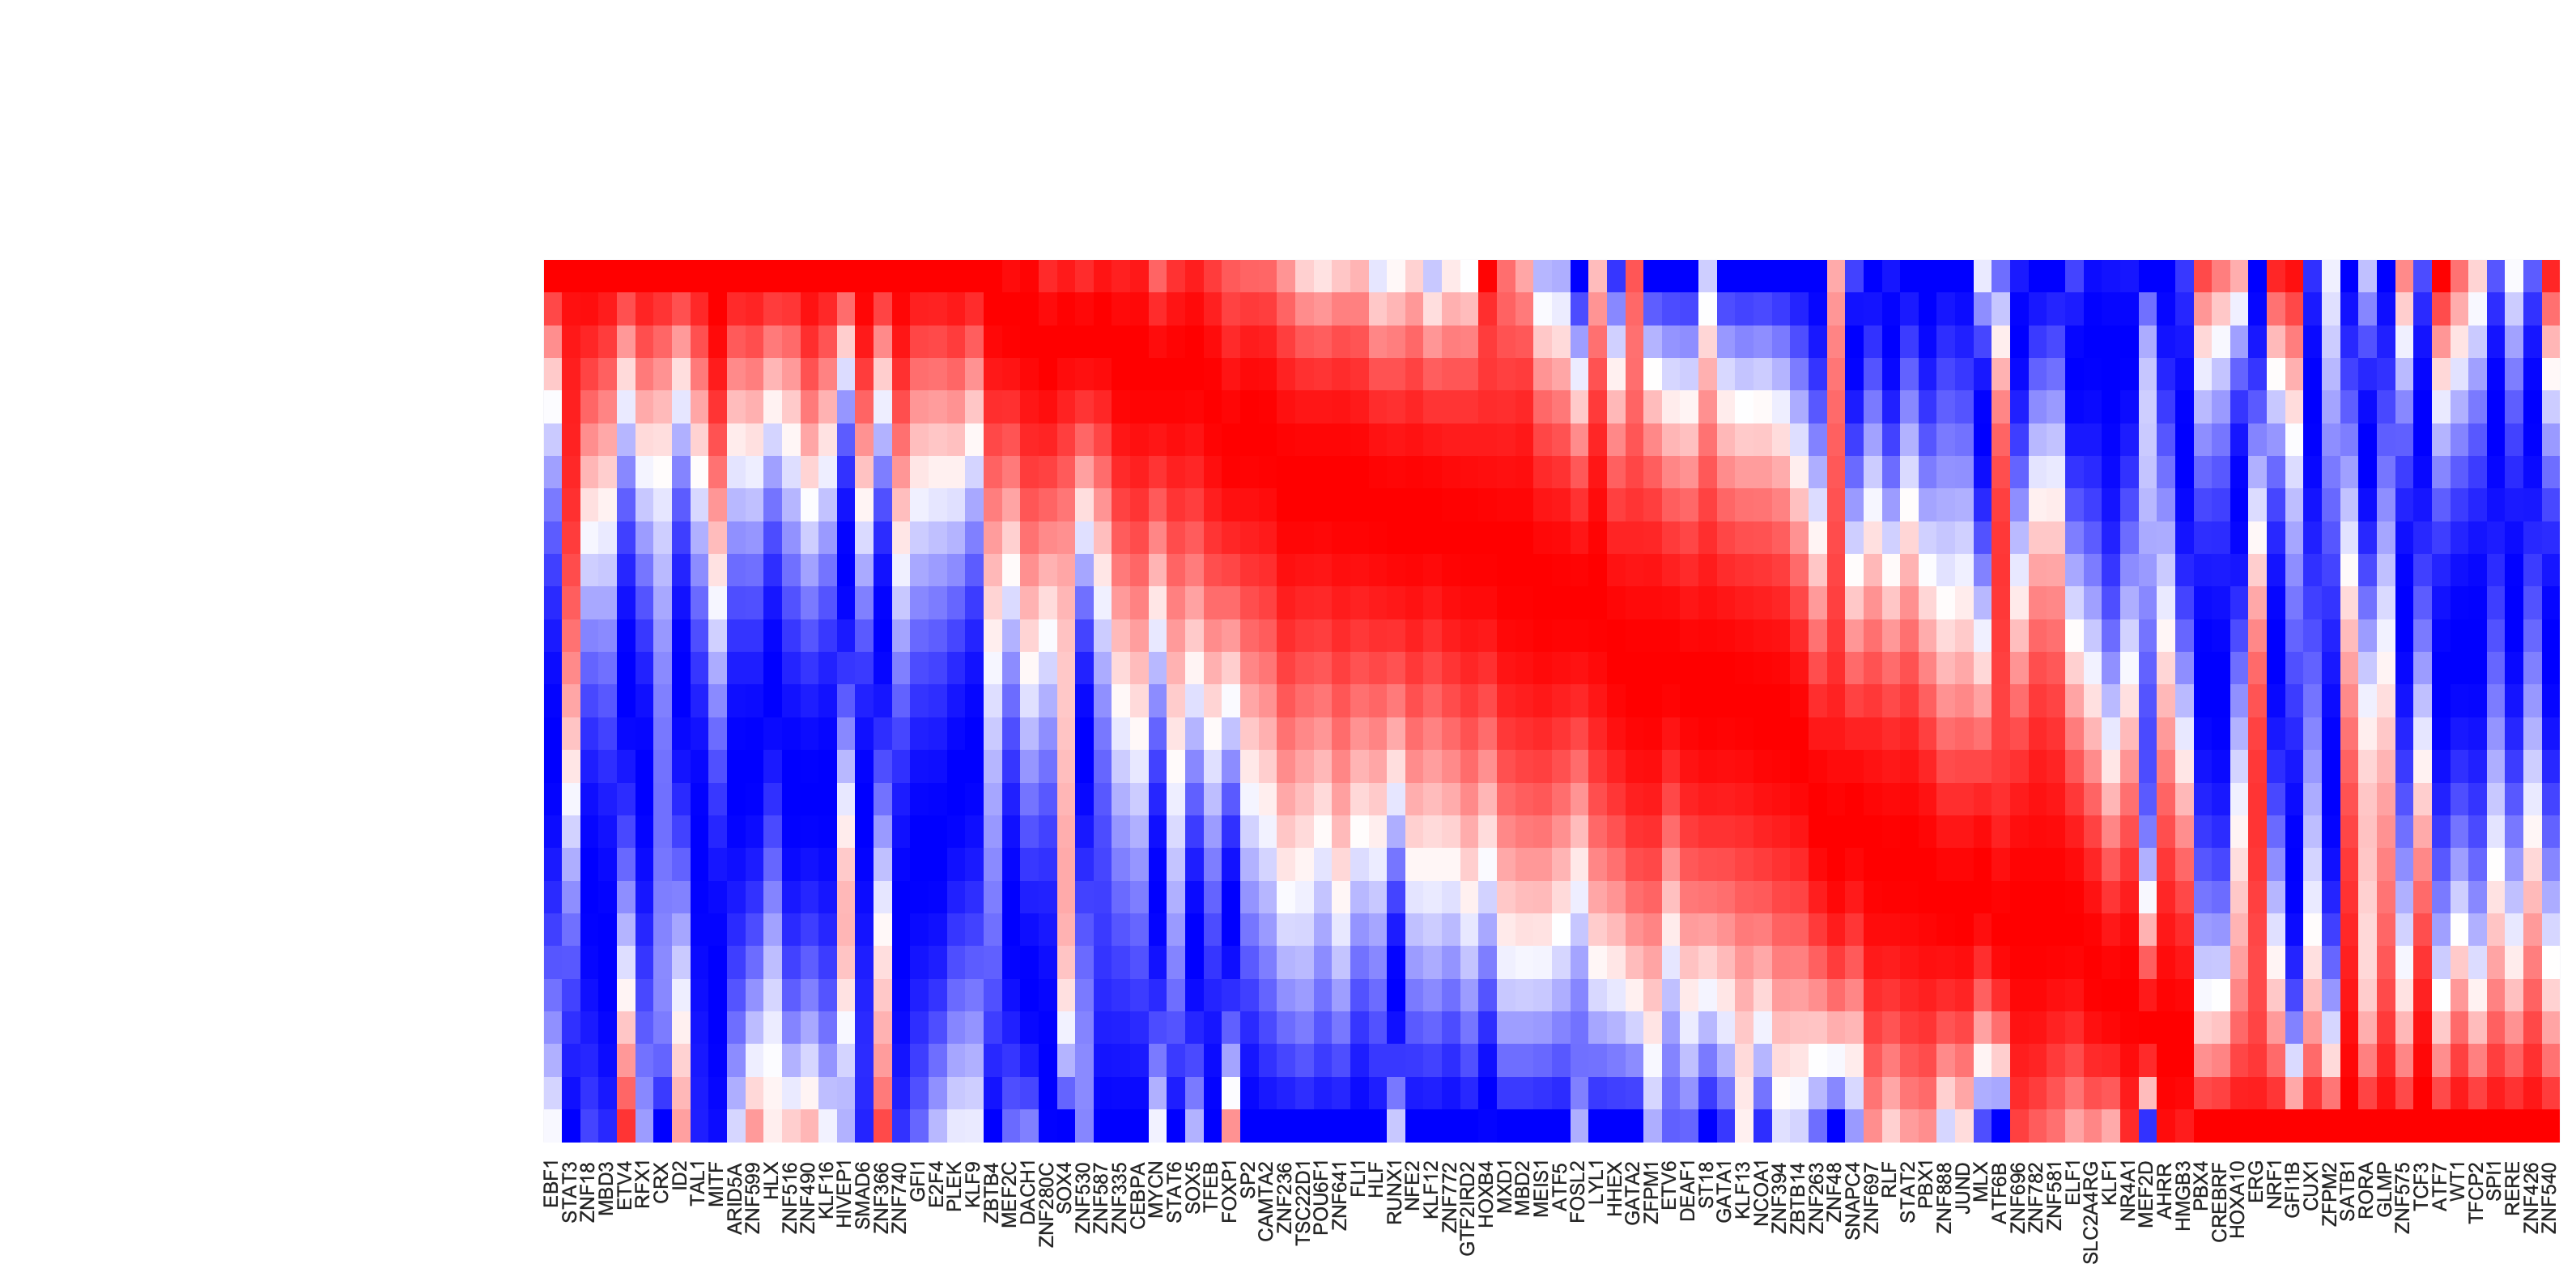

In [22]:
from matplotlib import pyplot, transforms

is_human_tfs = [gene in human_tfs_names for gene in adata_labeling.var_names[adata_labeling.var.use_for_transition]]
human_genes = adata_labeling.var_names[adata_labeling.var.use_for_transition][is_human_tfs]
lap = dyn.pd.least_action(
    adata_labeling,
    init_cells=target_cells,
    target_cells=init_cells,
    basis="pca",
    adj_key="cosine_transition_matrix",
)
sns.set(font_scale=0.8)
sns_heatmap = dyn.pl.kinetic_heatmap(
    adata_labeling,
    basis="pca",
    mode="lap",
    figsize=(16, 8),
    genes=human_genes,
    project_back_to_high_dim=True,
    save_show_or_return="return",
    color_map="bwr",
    transpose=True,
    xticklabels=True,
    yticklabels=False,
)
plt.setp(sns_heatmap.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()


## Evaluate TF rankings based on LAP analyses
As mentioned above, we can rank TFs based on the mean square displacement (MSD) along the LAP . In this section, we are going to evaluate rankings from LAP analyses by comparing with known transcription factors that enable the successful cell fate conversion, reported from literature. More details can be found in the dynamo paper :cite:p:`QIU2022`. 

We first prepare TF ranking dataframes that will be used to create ranking statistics in this
section. We first identify the TFs from all genes (``["TF"]`` key) and tag TFs that are known transcription factor for the corresponding cell fate conversion  (``["known_TF"]`` key). To the best we can, we all manually compiled all known factors for all known hematopoietic cell fate transitions (including developmental process). Please see supplementary table 2 from dynamo paper :cite:p:`QIU2022` for more details. 

This part is specific to our scNT-seq dataset but should be easily changed to meet your needs as well. 

In [23]:
%%capture
HSC_Meg_ranking = transition_graph["HSC->Meg"]["ranking"]
HSC_Meg_ranking["TF"] = [i in human_tfs_names for i in list(HSC_Meg_ranking["all"])]

HSC_Meg_ranking = HSC_Meg_ranking.query("TF == True")
HSC_Meg_ranking["known_TF"] = [
    i in ["GATA1", "GATA2", "ZFPM1", "GFI1B", "FLI1", "NFE2"] for i in list(HSC_Meg_ranking["all"])
]

HSC_Ery_ranking = transition_graph["HSC->Ery"]["ranking"]
HSC_Ery_ranking["TF"] = [i in human_tfs_names for i in list(HSC_Ery_ranking["all"])]

HSC_Ery_ranking = HSC_Ery_ranking.query("TF == True")
HSC_Ery_ranking["known_TF"] = [
    i in ["GATA1", "ZFPM1", "GFI1B", "KLF1", "SPI1", "GATA2", "LDB1", "TAL1", "ZFPM1"]
    for i in list(HSC_Ery_ranking["all"])
]

HSC_Bas_ranking = transition_graph["HSC->Bas"]["ranking"]
HSC_Bas_ranking["TF"] = [i in human_tfs_names for i in list(ranking["all"])]

HSC_Bas_ranking = HSC_Bas_ranking.query("TF == True")
HSC_Bas_ranking["known_TF"] = [i in ["CEBPA", "GATA2", "GATA1", "RUNX1"] for i in list(HSC_Bas_ranking["all"])]
HSC_Bas_ranking

HSC_Mon_ranking = transition_graph["HSC->Mon"]["ranking"]
HSC_Mon_ranking["TF"] = [i in human_tfs_names for i in list(ranking["all"])]

HSC_Mon_ranking = HSC_Mon_ranking.query("TF == True")
HSC_Mon_ranking["known_TF"] = [i in ["SPI1", "IRF8", "IRF5", "ZEB2", "KLF4"] for i in list(HSC_Mon_ranking["all"])]
HSC_Mon_ranking

HSC_Neu_ranking = transition_graph["HSC->Neu"]["ranking"]
HSC_Neu_ranking["TF"] = [i in human_tfs_names for i in list(HSC_Neu_ranking["all"])]

HSC_Neu_ranking = HSC_Neu_ranking.query("TF == True")
HSC_Neu_ranking["known_TF"] = [i in ["GFI1", "PER3", "GATA1", "ETS3"] for i in list(HSC_Neu_ranking["all"])]
HSC_Neu_ranking

#
Meg_HSC_ranking = transition_graph["Meg->HSC"]["ranking"]
Meg_HSC_ranking["TF"] = [i in human_tfs_names for i in list(Meg_HSC_ranking["all"])]

Meg_HSC_ranking = Meg_HSC_ranking.query("TF == True")
Meg_HSC_ranking["known_TF"] = [
    i in ["RUN1T1", "HLF", "LMO2", "PRDM5", "PBX1", "ZFP37", "MYCN", "MEIS1"] for i in list(Meg_HSC_ranking["all"])
]


# An erythroid to myeloid cell fate conversion is elicited by LSD1 inactivation
Ery_Mon_ranking = transition_graph["Ery->Mon"]["ranking"]
Ery_Mon_ranking["TF"] = [i in human_tfs_names for i in list(Ery_Mon_ranking["all"])]

Ery_Mon_ranking = Ery_Mon_ranking.query("TF == True")
Ery_Mon_ranking["known_TF"] = [i in ["LSD1", "RUNX1"] for i in list(Ery_Mon_ranking["all"])]

Ery_Neu_ranking = transition_graph["Ery->Neu"]["ranking"]
Ery_Neu_ranking["TF"] = [i in human_tfs_names for i in list(Ery_Neu_ranking["all"])]

Ery_Neu_ranking = Ery_Neu_ranking.query("TF == True")
Ery_Neu_ranking["known_TF"] = [i in ["LSD1", "RUNX1"] for i in list(Ery_Neu_ranking["all"])]

# http://genesdev.cshlp.org/content/20/21/3010.long

Mon_Bas_ranking = transition_graph["Mon->Bas"]["ranking"]
Mon_Bas_ranking["TF"] = [i in human_tfs_names for i in list(Mon_Bas_ranking["all"])]

Mon_Bas_ranking = Mon_Bas_ranking.query("TF == True")
Mon_Bas_ranking["known_TF"] = [i in ["GATA2", "CEBPA"] for i in list(Mon_Bas_ranking["all"])]

Neu_Bas_ranking = transition_graph["Neu->Bas"]["ranking"]
Neu_Bas_ranking["TF"] = [i in human_tfs_names for i in list(Neu_Bas_ranking["all"])]

Neu_Bas_ranking = Neu_Bas_ranking.query("TF == True")
Neu_Bas_ranking["known_TF"] = [i in ["GATA2", "CEBPA"] for i in list(Mon_Bas_ranking["all"])]


# GATA-1 Converts Lymphoid and Myelomonocytic Progenitors into the Megakaryocyte/Erythrocyte Lineages

Mon_Meg_ranking = transition_graph["Mon->Meg"]["ranking"]
Mon_Meg_ranking["TF"] = [i in human_tfs_names for i in list(Mon_Meg_ranking["all"])]

Mon_Meg_ranking = Mon_Meg_ranking.query("TF == True")
Mon_Meg_ranking["known_TF"] = [i in ["GATA1", "ZFPM1", "GATA2"] for i in list(Mon_Meg_ranking["all"])]

Mon_Ery_ranking = transition_graph["Mon->Ery"]["ranking"]
Mon_Ery_ranking["TF"] = [i in human_tfs_names for i in list(Mon_Ery_ranking["all"])]

Mon_Ery_ranking = Mon_Ery_ranking.query("TF == True")
Mon_Ery_ranking["known_TF"] = [i in ["GATA1", "ZFPM1", "GATA2"] for i in list(Mon_Ery_ranking["all"])]


# Tom's paper
Meg_Neu_ranking = transition_graph["Meg->Neu"]["ranking"]
Meg_Neu_ranking["TF"] = [i in human_tfs_names for i in list(Meg_Neu_ranking["all"])]

Meg_Neu_ranking = Meg_Neu_ranking.query("TF == True")
Meg_Neu_ranking["known_TF"] = [i in ["CEBPA", "CEBPB", "CEBPE", "SPI1"] for i in list(Meg_Neu_ranking["all"])]

Ery_Neu_ranking = transition_graph["Ery->Neu"]["ranking"]
Ery_Neu_ranking["TF"] = [i in human_tfs_names for i in list(Ery_Neu_ranking["all"])]

Ery_Neu_ranking = Ery_Neu_ranking.query("TF == True")
Ery_Neu_ranking["known_TF"] = [i in ["CEBPA", "CEBPB", "CEBPE", "SPI1"] for i in list(Ery_Neu_ranking["all"])]


In [24]:
lap_dict = transition_graph[cell_type[0] + "->" + cell_type[3]]["LAP_pca"]
lap_dict["t"] *= 3
adata_labeling.uns["LAP_pca"] = lap_dict


### Ranking TF's importance for each LAP

Let's re-rank each known TF from each known hematopoietic fate conversion based on their MSD rankings among all TFs. We will use the helper function
``assign_tf_ranks`` to achieve this purpose. All the known TFs are collected from literature as mentioned above.


In [25]:
def assign_tf_ranks(transition_graph: dict, transition: str, tfs: list, tfs_key="TFs", tfs_rank_key="TFs_rank"):
    ranking = transition_graph[transition]["ranking"]
    ranking["TF"] = [i in human_tfs_names for i in list(ranking["all"])]
    true_tf_list = list(ranking.query("TF == True")["all"])
    all_tfs = list(ranking.query("TF == True")["all"])
    transition_graph[transition][tfs_key] = tfs

    transition_graph[transition][tfs_rank_key] = [
        all_tfs.index(key) if key in true_tf_list else -1 for key in transition_graph[transition][tfs_key]
    ]


assign_tf_ranks(transition_graph, "HSC->Meg", ["GATA1", "GATA2", "ZFPM1", "GFI1B", "FLI1", "NFE2"])


In [26]:
transition_graph["HSC->Meg"]["TFs"]


['GATA1', 'GATA2', 'ZFPM1', 'GFI1B', 'FLI1', 'NFE2']

In [27]:
assign_tf_ranks(
    transition_graph, "HSC->Ery", ["GATA1", "ZFPM1", "GFI1B", "KLF1", "SPI1", "GATA2", "LDB1", "TAL1", "ZFPM1"]
)


In [28]:
assign_tf_ranks(transition_graph, "HSC->Bas", ["STAT5", "GATA2", "CEBPA", "MITF"])
assign_tf_ranks(transition_graph, "HSC->Bas", ["CEBPA", "GATA2", "GATA1", "RUNX1"])


In [29]:
assign_tf_ranks(transition_graph, "HSC->Mon", ["SPI1", "IRF8", "IRF5", "ZEB2", "KLF4"])


In [30]:
assign_tf_ranks(transition_graph, "HSC->Neu", ["GFI1", "PER3", "GATA1", "ETS3"])


In [31]:
assign_tf_ranks(transition_graph, "Meg->HSC", ["RUN1T1", "HLF", "LMO2", "PRDM5", "PBX1", "ZFP37", "MYCN", "MEIS1"])


In [32]:
assign_tf_ranks(transition_graph, "Mon->Meg", ["GATA1", "ZFPM1", "GATA2"])


In [33]:
assign_tf_ranks(transition_graph, "Mon->Ery", ["GATA1", "ZFPM1", "GATA2"])


In [34]:
assign_tf_ranks(transition_graph, "Meg->Neu", ["CEBPA", "CEBPB", "CEBPE", "SPI1"])


In [35]:
# Tom's paper
assign_tf_ranks(
    transition_graph, "Ery->Neu", ["CEBPA", "CEBPB", "CEBPE", "SPI1"], tfs_rank_key="TFs_rank2", tfs_key="TFs2"
)


An erythroid to myeloid cell fate conversion is elicited by LSD1 inactivation


In [36]:
assign_tf_ranks(transition_graph, "Ery->Mon", ["LSD1", "RUNX1"])
assign_tf_ranks(transition_graph, "Ery->Neu", ["LSD1", "RUNX1"], tfs_rank_key="TFs_rank1", tfs_key="TFs1")


In [37]:
# http://genesdev.cshlp.org/content/20/21/3010.long
assign_tf_ranks(transition_graph, "Mon->Bas", ["GATA2", "CEBPA"])

assign_tf_ranks(transition_graph, "Neu->Bas", ["GATA2", "CEBPA"])


In [38]:
transition_graph["Ery->Neu"]["TFs2"], transition_graph["Ery->Neu"]["TFs_rank2"]


(['CEBPA', 'CEBPB', 'CEBPE', 'SPI1'], [0, -1, -1, 17])

Here we will convert the rankings of known TFs to a priority score, simply defined as $1 - \frac{\# rank}{\# TF}$.


In [39]:
from functools import reduce

reprogramming_mat_dict = {
    "HSC->Meg": {
        "genes": transition_graph["HSC->Meg"]["TFs"],
        "rank": transition_graph["HSC->Meg"]["TFs_rank"],
        "PMID": 18295580,
    },
    "HSC->Ery": {
        "genes": transition_graph["HSC->Ery"]["TFs"],
        "rank": transition_graph["HSC->Ery"]["TFs_rank"],
        "PMID": 18295580,
    },
    "HSC->Bas": {
        "genes": transition_graph["HSC->Ery"]["TFs"],
        "rank": transition_graph["HSC->Ery"]["TFs_rank"],
        "PMID": 18295580,
    },
    "HSC->Mon": {
        "genes": transition_graph["HSC->Mon"]["TFs"],
        "rank": transition_graph["HSC->Mon"]["TFs_rank"],
        "PMID": 18295580,
    },
    "HSC->Neu": {
        "genes": transition_graph["HSC->Neu"]["TFs"],
        "rank": transition_graph["HSC->Neu"]["TFs_rank"],
        "PMID": 18295580,
    },
    "Meg->HSC": {
        "genes": transition_graph["Meg->HSC"]["TFs"],
        "rank": transition_graph["Meg->HSC"]["TFs_rank"],
        "PMID": 24766805,
    },
    "Meg->Neu": {
        "genes": transition_graph["Meg->Neu"]["TFs"],
        "rank": transition_graph["Meg->Neu"]["TFs_rank"],
        "PMID": 31395745,
    },
    "Ery->Mon": {
        "genes": transition_graph["Ery->Mon"]["TFs"],
        "rank": transition_graph["Ery->Mon"]["TFs_rank"],
        "PMID": 34324630,
    },
    "Ery->Neu1": {
        "genes": transition_graph["Ery->Neu"]["TFs1"],
        "rank": transition_graph["Ery->Neu"]["TFs_rank1"],
        "PMID": 31395745,
    },
    "Ery->Neu2": {
        "genes": transition_graph["Ery->Neu"]["TFs2"],
        "rank": transition_graph["Ery->Neu"]["TFs_rank2"],
        "PMID": 34324630,
    },
    "Mon->Meg": {
        "genes": transition_graph["Mon->Meg"]["TFs"],
        "rank": transition_graph["Mon->Meg"]["TFs_rank"],
        "PMID": 14499119,
    },
    "Mon->Ery": {
        "genes": transition_graph["Mon->Ery"]["TFs"],
        "rank": transition_graph["Mon->Ery"]["TFs_rank"],
        "PMID": 14499119,
    },
    "Mon->Bas": {
        "genes": transition_graph["Mon->Bas"]["TFs"],
        "rank": transition_graph["Mon->Bas"]["TFs_rank"],
        "PMID": 17079688,
    },
    "Neu->Bas": {
        "genes": transition_graph["Neu->Bas"]["TFs"],
        "rank": transition_graph["Neu->Bas"]["TFs_rank"],
        "PMID": 17079688,
    },
}


reprogramming_mat_df = pd.DataFrame(reprogramming_mat_dict)

for key in reprogramming_mat_df:
    assert len(reprogramming_mat_df[key]["genes"]) == len(reprogramming_mat_df[key]["rank"]), str(key)


all_genes = reduce(lambda a, b: a + b, reprogramming_mat_df.loc["genes", :])
all_rank = reduce(lambda a, b: a + b, reprogramming_mat_df.loc["rank", :])
all_keys = np.repeat(
    np.array(list(reprogramming_mat_dict.keys())), [len(i) for i in reprogramming_mat_df.loc["genes", :]]
)

reprogramming_mat_df_p = pd.DataFrame({"genes": all_genes, "rank": all_rank, "transition": all_keys})
reprogramming_mat_df_p = reprogramming_mat_df_p.query("rank > -1")
reprogramming_mat_df_p["type"] = reprogramming_mat_df_p["transition"].map(
    {
        "HSC->Meg": "development",
        "HSC->Ery": "development",
        "HSC->Bas": "development",
        "HSC->Mon": "development",
        "HSC->Neu": "development",
        "Meg->HSC": "reprogramming",
        "Meg->Neu": "transdifferentiation",
        "Ery->Mon": "transdifferentiation",
        "Ery->Neu1": "transdifferentiation",
        "Ery->Neu2": "transdifferentiation",
        "Mon->Meg": "transdifferentiation",
        "Mon->Ery": "transdifferentiation",
        "Mon->Bas": "transdifferentiation",
        "Neu->Bas": "transdifferentiation",
    }
)

reprogramming_mat_df_p["rank"] /= 133
reprogramming_mat_df_p["rank"] = 1 - reprogramming_mat_df_p["rank"]


### Plotting priority scores of known TFs for specific hematopoietic trandifferentiations
The y-axis is the hematopoietic trandifferentiation and the x-axis the TF priority scores for a specific transition.


/var/folders/m5/dc_kmwcs2_3fqkytr_j09wx00000gn/T/ipykernel_37240/2301077297.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reprogramming_mat_dict.keys())[6:], rotation=0)
/var/folders/m5/dc_kmwcs2_3fqkytr_j09wx00000gn/T/ipykernel_37240/2301077297.py:46: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


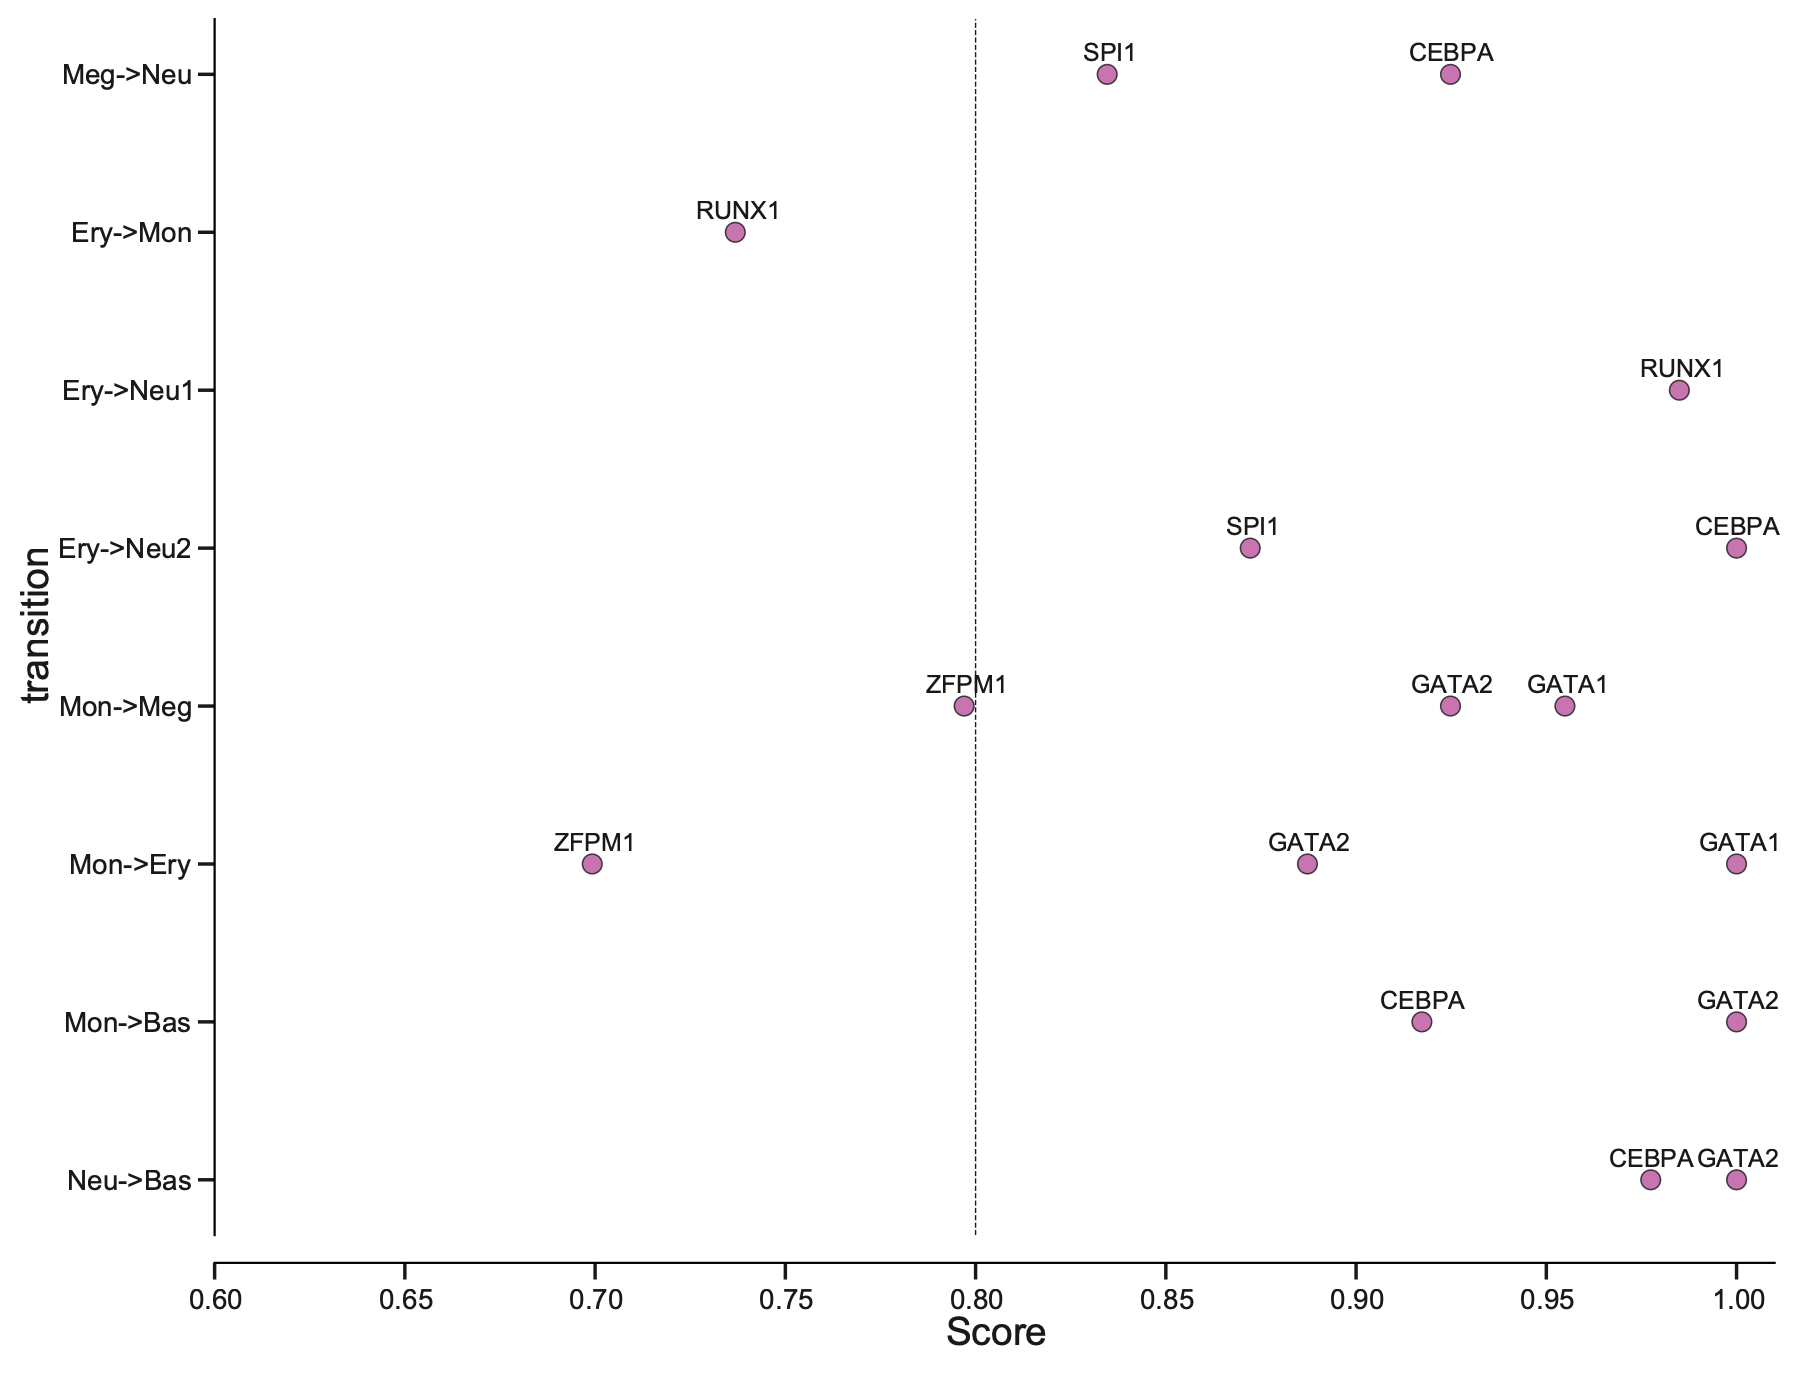

In [40]:
dyn.configuration.set_pub_style()
transition_color_dict = {"development": "#2E3192", "reprogramming": "#EC2227", "transdifferentiation": "#B9519E"}

reprogramming_mat_df_p_subset = reprogramming_mat_df_p.query("type == 'transdifferentiation'")
rank = reprogramming_mat_df_p_subset["rank"].values
transition = reprogramming_mat_df_p_subset["transition"].values
genes = reprogramming_mat_df_p_subset["genes"].values

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.scatterplot(
    y="transition",
    x="rank",
    data=reprogramming_mat_df_p_subset,
    ec=None,
    hue="type",
    alpha=0.8,
    ax=ax,
    s=50,
    palette=transition_color_dict,
    clip_on=False,
)

for i in range(reprogramming_mat_df_p_subset.shape[0]):
    annote_text = genes[i]  # STK_ID
    ax.annotate(
        annote_text, xy=(rank[i], transition[i]), xytext=(0, 3), textcoords="offset points", ha="center", va="bottom",
        fontsize=9
    )

plt.axvline(0.8, linestyle="--", lw=0.5)
ax.set_xlim(0.6, 1.01)
ax.set_xlabel("Score",  fontsize=14)
ax.set_ylabel("transition",  fontsize=14)
ax.set_yticklabels(list(reprogramming_mat_dict.keys())[6:], rotation=0)
ax.legend().set_visible(False)
ax.spines.top.set_position(("outward", 10))
ax.spines.bottom.set_position(("outward", 10))

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")


plt.tick_params(axis='both', which='both', labelsize=10)
plt.show()



From the above plot, you can appreciate that our prediction works very well. Majority of the known TFs of the known transitions are prioritized as > 0.8 while some of them achiving perfect prioritization (score ~= 1).

## ROC curve analyses of TF priorization of the LAP predictions
Last but not least, let us evaluate our TF ranking via receiver operating curve (ROC) analyses. ROC of LAP TF prioritization predictions when using all known genes of all known transitions as the gold standard (see STAR Methods of :cite:p:`QIU2022`) reveals an AUC (area under curve) of ``0.83``, again indicating our LAP predictions and TFs prioritization works quiet well. 

These analyses reveal the potential of the LAP approach to predict the optimal paths and TF cocktails of cell-fate transitions with high accuracy, paving the road for à la carte reprogramming between any cell types of interest for applications in regenerative medicine (Graf and Enver, 2009).

In [41]:
all_ranks_list = [
    HSC_Meg_ranking,
    HSC_Ery_ranking,
    HSC_Bas_ranking,
    HSC_Mon_ranking,
    HSC_Neu_ranking,
    Meg_HSC_ranking,
    Ery_Mon_ranking,
    Ery_Neu_ranking,
    Mon_Bas_ranking,
    Neu_Bas_ranking,
    Mon_Meg_ranking,
    Mon_Ery_ranking,
    Meg_Neu_ranking,
    Ery_Neu_ranking,
]

all_ranks_df = pd.concat(all_ranks_list)

all_ranks_df["priority_score"] = (
    1 - np.tile(np.arange(HSC_Bas_ranking.shape[0]), len(all_ranks_list)) / HSC_Bas_ranking.shape[0]
)
# all_ranks_df['priority_score'].hist()
TFs = ranking["all"][ranking["TF"]].values
valid_TFs = np.unique(reprogramming_mat_df_p["genes"].values)


/var/folders/m5/dc_kmwcs2_3fqkytr_j09wx00000gn/T/ipykernel_37240/1617295339.py:35: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


<Figure size 130x100 with 0 Axes>

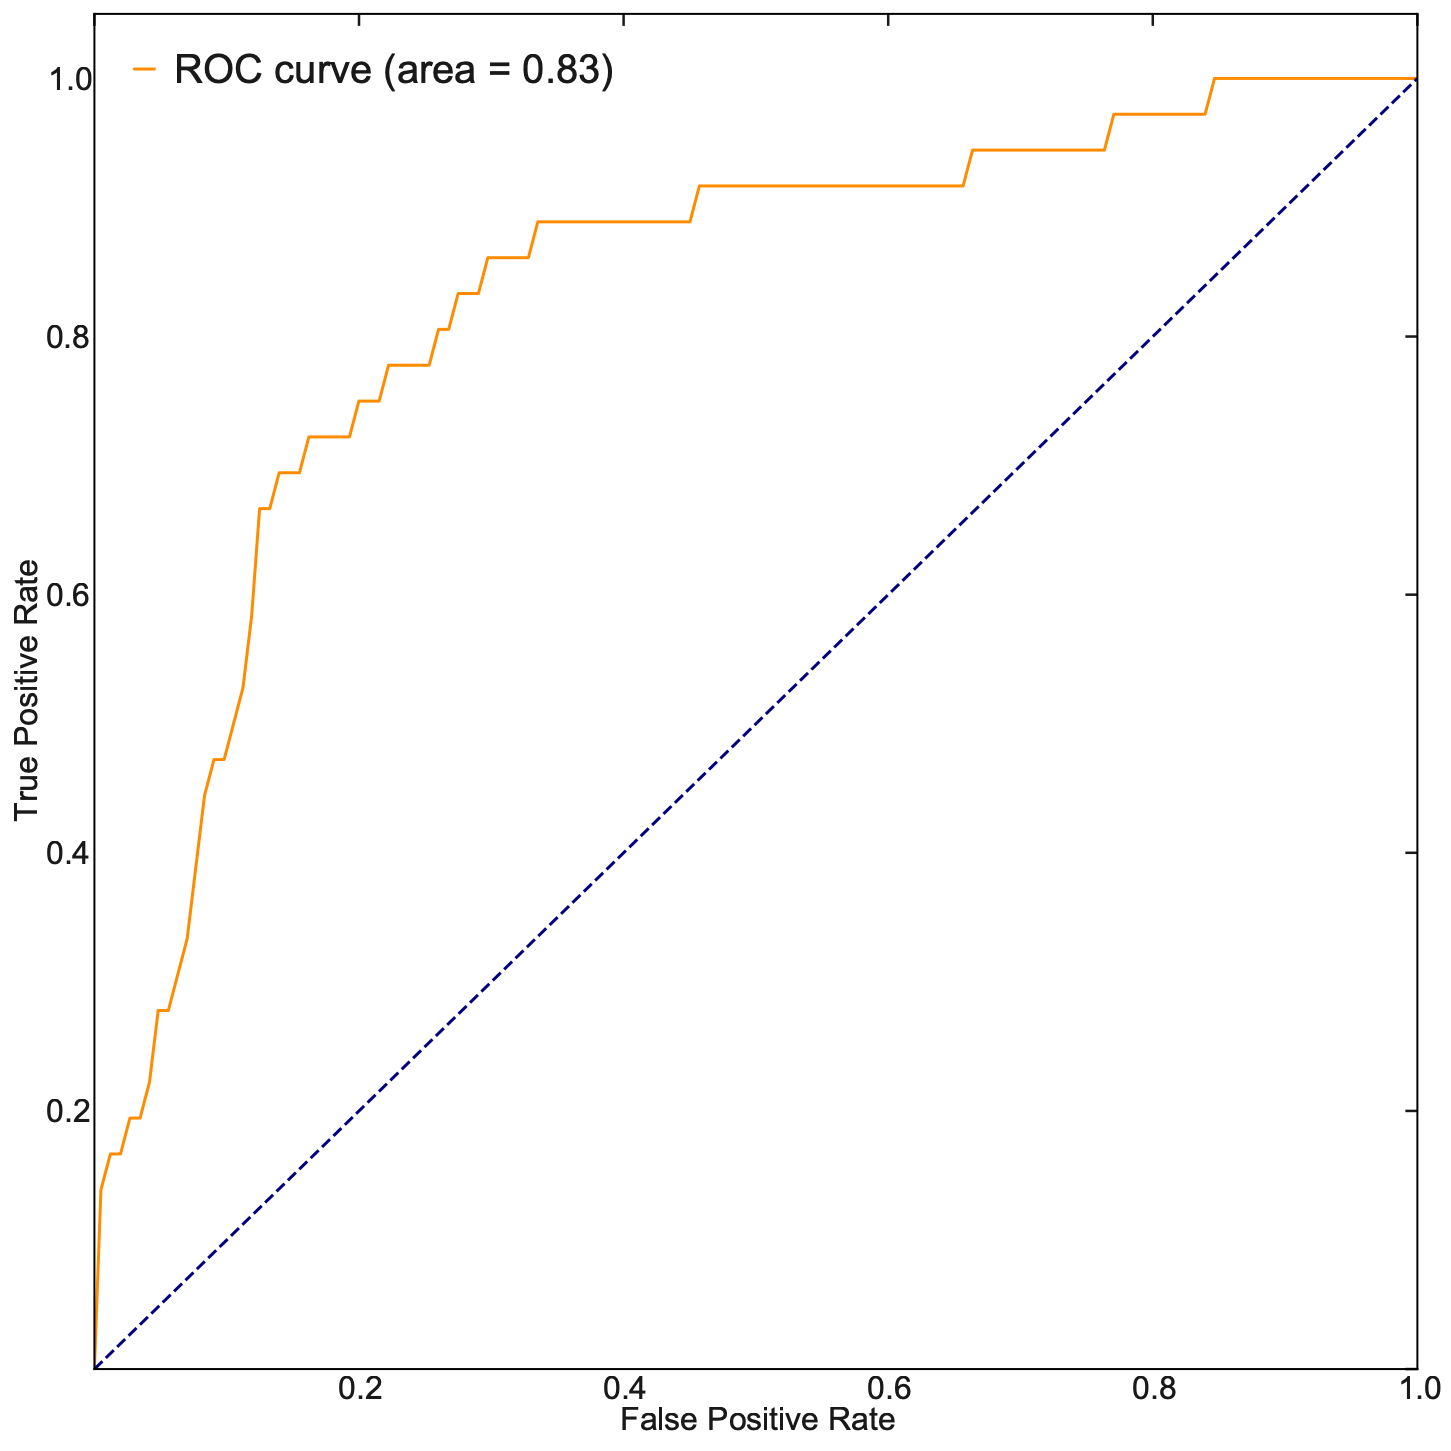

In [42]:
from sklearn.metrics import roc_curve, auc

use_abs = False
top_genes = len(TFs)

cls = all_ranks_df["known_TF"].astype(int)
pred = all_ranks_df["priority_score"]

fpr, tpr, _ = roc_curve(cls, pred)
roc_auc = auc(fpr, tpr)


dyn.configuration.set_pub_style_mpltex()
plt.figure(figsize=(1.3, 1))

lw = 1.5
fontsize=16
figure = plt.figure(figsize=(10, 10))

plt.tick_params(axis='both', which='both', labelsize=16)
plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=fontsize)
plt.ylabel("True Positive Rate", fontsize=fontsize)

# remove first x, y axis 0 tick
ax = plt.gca()
plt.setp(ax.get_yticklabels()[0], visible=False)    
plt.setp(ax.get_xticklabels()[0], visible=False)
# plt.title(cur_guide)
plt.legend(loc="lower right")
plt.legend(loc=2, prop={'size': 20})
plt.show()

plt.tight_layout()
